<a href="https://colab.research.google.com/github/RehanMahmoodFarooqi/DAV_Project/blob/main/DAV_project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Group Members:**

Muhammad Usman

Tahir Iqbal

Rehan Mahmood Farooqi




# Data Gathering:

The following is the screpper using selenium as library:

In [ ]:
import time
from selenium import webdriver
from selenium.webdriver.common.by import By
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.chrome.options import Options
from selenium.common.exceptions import TimeoutException, NoSuchElementException, ElementClickInterceptedException
from selenium.webdriver.common.action_chains import ActionChains
import re
import os

def scrape_ncbi_monkeypox(start_page=1, end_page=5, max_retries=3):
    """
    Scrape monkeypox nucleotide data from NCBI's Nuccore database

    Args:
        start_page (int): First page to scrape
        end_page (int): Last page to scrape
        max_retries (int): Maximum number of retry attempts for each item
    """
    chrome_options = Options()
    chrome_options.add_argument("--disable-notifications")
    chrome_options.add_argument("--start-maximized")
    chrome_options.add_argument("--disable-gpu")
    chrome_options.add_argument("--disable-software-rasterizer")

    # Add a unique user data directory argument
    chrome_options.add_argument("--user-data-dir=/tmp/chrome_data")  # or specify a directory of your choice

    driver = webdriver.Chrome(options=chrome_options)


    # Navigate to NCBI Nuccore
    print(f"Opening NCBI Nuccore database...")
    driver.get("https://www.ncbi.nlm.nih.gov/nuccore")

    # Search for monkeypox
    print(f"Searching for monkeypox...")
    search_box = driver.find_element(By.ID, "term")
    search_box.send_keys("monkeypox")
    search_button = driver.find_element(By.ID, "search")
    search_button.click()

    # Wait for results to load
    try:
        WebDriverWait(driver, 10).until(
            EC.presence_of_element_located((By.CLASS_NAME, "result_count"))
        )
        print("Search results loaded successfully")
    except TimeoutException:
        print("Timed out waiting for results to load")
        driver.quit()
        return

    # Create output file if it doesn't exist or append to existing file
    output_file = "data.txt"
    if not os.path.exists(output_file):
        with open(output_file, 'w', encoding='utf-8') as f:
            # Create empty file if it doesn't exist
            pass

    # Function to check if an item has been successfully processed
    def is_item_processed(page_num, item_num):
        if not os.path.exists(output_file):
            return False

        with open(output_file, 'r', encoding='utf-8') as f:
            content = f.read()
            # Check if the metadata for this specific item exists in the file
            pattern = rf"{page_num}, {item_num},"
            return re.search(pattern, content) is not None

    # Navigate to the start page
    if start_page > 1:
        try:
            print(f"Navigating to start page {start_page}...")
            # Wait for page navigation elements to be available
            WebDriverWait(driver, 10).until(
                EC.presence_of_element_located((By.ID, "pageno2"))
            )

            page_input = driver.find_element(By.ID, "pageno2")
            page_input.clear()
            page_input.send_keys(str(start_page))
            page_input.send_keys(Keys.ENTER)

            # Wait for page to load
            time.sleep(3)
            print(f"Successfully navigated to page {start_page}")
        except Exception as e:
            print(f"Error navigating to start page: {e}")
            driver.quit()
            return

    # Process pages
    current_page = start_page

    while current_page <= end_page:
        print(f"Processing page {current_page}...")

        # Wait for results to load completely
        time.sleep(2)

        # Get all result items on the page
        try:
            result_items = driver.find_elements(By.CSS_SELECTOR, "div.rslt")
            print(f"Found {len(result_items)} results on this page")

            for idx, item in enumerate(result_items):
                item_num = idx + 1
                # Check if this item has already been processed
                if is_item_processed(current_page, item_num):
                    print(f"Item {item_num} on page {current_page} already processed. Skipping...")
                    continue

                # Retry loop for each item
                for retry_count in range(max_retries):
                    try:
                        if retry_count > 0:
                            print(f"Retry attempt {retry_count} for item {item_num}")
                            # Refresh the list of items
                            result_items = driver.find_elements(By.CSS_SELECTOR, "div.rslt")
                            if idx < len(result_items):
                                item = result_items[idx]
                            else:
                                print(f"Item {item_num} not found after page refresh. Skipping...")
                                break

                        # Extract title/name
                        title_element = item.find_element(By.CSS_SELECTOR, "p.title a")
                        title_text = title_element.text.strip()
                        print(f"Processing item {item_num}: {title_text[:50]}...")

                        # Extract bp length
                        desc_element = item.find_element(By.CSS_SELECTOR, "p.desc")
                        desc_text = desc_element.text.strip()

                        # Modified regex to capture full bp length including commas
                        bp_match = re.search(r'([\d,]+)\s+bp', desc_text)
                        bp_length = bp_match.group(1) if bp_match else "Unknown"

                        # Extract linear/circular information
                        linear_match = re.search(r'(linear|circular)', desc_text, re.IGNORECASE)
                        linear_info = linear_match.group(1) if linear_match else "linear"  # default to linear

                        # Get direct FASTA URL from the title link
                        # Get the base URL from title link
                        title_href = title_element.get_attribute("href")
                        if not title_href:
                            print(f"Could not get URL for item {item_num}")
                            continue

                        # Transform to FASTA URL
                        accession_match = re.search(r'/nuccore/([^?]+)', title_href)
                        if not accession_match:
                            print(f"Could not extract accession number for item {item_num}")
                            continue

                        accession = accession_match.group(1)
                        fasta_url = f"https://www.ncbi.nlm.nih.gov/nuccore/{accession}?report=fasta"

                        # Open FASTA URL in new tab
                        driver.execute_script("window.open(arguments[0]);", fasta_url)

                        # Switch to the new tab
                        time.sleep(1)
                        original_window = driver.current_window_handle
                        for window_handle in driver.window_handles:
                            if window_handle != original_window:
                                driver.switch_to.window(window_handle)
                                break

                        # Wait for FASTA content to load
                        WebDriverWait(driver, 10).until(
                            EC.presence_of_element_located((By.TAG_NAME, "pre"))
                        )

                        # Extract the FASTA content
                        fasta_element = driver.find_element(By.TAG_NAME, "pre")
                        fasta_text = fasta_element.text

                        # Extract only the sequence part (without header)
                        sequence_lines = fasta_text.strip().split('\n')

                        # Get the header (first line) and remove the '>' character
                        header = sequence_lines[0][1:].strip() if sequence_lines[0].startswith('>') else sequence_lines[0].strip()

                        # Join all the sequence lines (excluding header) into a single continuous string
                        sequence = ''.join(sequence_lines[1:]).replace(' ', '')

                        # Format: "page number, item number, Name of library, bp string length linear" as metadata
                        metadata = f"{current_page}, {item_num}, {title_text}, {bp_length} {linear_info}"

                        # Write data to file in the required format, using append mode
                        with open(output_file, 'a', encoding='utf-8') as f:
                            f.write(f"{metadata}\n")
                            f.write(f"{sequence}\n")
                            f.write("\n")  # Empty line after each entry

                        print(f"Successfully processed item {item_num}")

                        # Close this tab and switch back to results
                        driver.close()
                        driver.switch_to.window(original_window)

                        # If we get here, the item was successfully processed
                        break

                    except Exception as e:
                        print(f"Error processing item {item_num}: {e}")
                        # Try to close any additional tabs and go back to main window
                        try:
                            if len(driver.window_handles) > 1:
                                # If we're not in the original window, switch back
                                if driver.current_window_handle != original_window:
                                    driver.close()
                                    driver.switch_to.window(original_window)
                        except Exception as tab_error:
                            print(f"Error cleaning up tabs: {tab_error}")

                        # If this was the last retry attempt, log it
                        if retry_count == max_retries - 1:
                            print(f"Failed to process item {item_num} after {max_retries} attempts")
                        else:
                            # Wait a moment before retry
                            time.sleep(2)

            # Navigate to next page if not the last page
            if current_page < end_page:
                try:
                    # Find the page input box
                    page_input = driver.find_element(By.ID, "pageno2")

                    # Get the max page number
                    page_text = driver.find_element(By.CSS_SELECTOR, "h3.page").text
                    max_page_match = re.search(r'of (\d+)', page_text)
                    max_page = int(max_page_match.group(1)) if max_page_match else 1

                    # Check if requested end_page is greater than max_page
                    if end_page > max_page:
                        end_page = max_page
                        print(f"Adjusted end_page to {max_page} (max available)")

                    if current_page < max_page:
                        # Clear and set new page number
                        page_input.clear()
                        page_input.send_keys(str(current_page + 1))
                        page_input.send_keys(Keys.ENTER)

                        # Wait for next page to load
                        time.sleep(3)
                        print(f"Navigated to page {current_page + 1}")
                    else:
                        print(f"Reached the last page ({max_page})")
                        break
                except Exception as e:
                    print(f"Error navigating to next page: {e}")
                    break

            current_page += 1

        except Exception as e:
            print(f"Error processing page {current_page}: {e}")
            break

    print(f"Scraping completed. Data saved to {output_file}")
    driver.quit()

if __name__ == "__main__":
    # Get user input for page range
    try:
        start_page = int(input("Enter start page number (default 1): ") or 1)
        end_page = int(input("Enter end page number (default 5): ") or 5)
        max_retries = int(input("Enter maximum retry attempts per item (default 3): ") or 3)

        if start_page < 1:
            start_page = 1
            print("Start page set to 1 (minimum value)")
        if end_page < start_page:
            end_page = start_page
            print(f"End page set to {start_page} (cannot be less than start page)")
    except ValueError:
        print("Invalid input, using default values: pages 1-5 with 3 retries per item")
        start_page, end_page, max_retries = 1, 5, 3

    scrape_ncbi_monkeypox(start_page, end_page, max_retries)

KeyboardInterrupt: Interrupted by user

In [ ]:
!pip install selenium


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.4/9.4 MB 76.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 499.2/499.2 kB 33.1 MB/s eta 0:00:00


# Data Loading:

First run this code to mount your google drive:

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


# Data Transformation:
In this phase we will convert string data into the tabular data.

In [3]:
import pandas as pd
import itertools
from collections import defaultdict
import re

def generate_triplet_columns():
    """Generate all possible 3-character combinations of A, T, G, C (4^3 = 64 combinations)."""
    nucleotides = ['A', 'T', 'G', 'C']
    triplets = [''.join(combo) for combo in itertools.product(nucleotides, repeat=3)]
    return sorted(triplets)  # Sort for consistent column order

def process_sequence(sequence):
    """
    Process a single sequence to count triplets, N's, and character counts.
    Returns a dictionary with triplet counts, N count, and character counts.
    """
    triplet_counts = defaultdict(int)
    n_count = 0
    counted_chars = 0

    # Count total characters (excluding invalid chars) and N's
    for char in sequence:
        if char in ['A', 'T', 'G', 'C']:
            counted_chars += 1
        elif char == 'N':
            n_count += 1

    # Process 3-character sliding window
    for i in range(len(sequence) - 2):
        triplet = sequence[i:i+3]
        # Skip triplets containing 'N'
        if 'N' not in triplet and len(triplet) == 3 and all(c in ['A', 'T', 'G', 'C'] for c in triplet):
            triplet_counts[triplet] += 1

    return triplet_counts, n_count, counted_chars

def parse_text_file(file_path):
    """
    Parse the text file to extract genome sequence entries.
    Returns a list of dictionaries with parsed data.
    """
    entries = []
    current_entry = None

    try:
        with open(file_path, 'r') as file:
            for line in file:
                line = line.strip()
                if not line:
                    continue

                # Check if the line starts with a number (indicating a new entry)
                if re.match(r'^\d+,\s*\d+', line):
                    if current_entry:
                        entries.append(current_entry)
                    # Split the line into components
                    parts = [part.strip() for part in line.split(',', 3)]
                    if len(parts) < 4:
                        print(f"Warning: Skipping malformed line: {line}")
                        continue
                    page_number, item_number, genome_name, expected_info = parts
                    # Extract expected character count (e.g., "453 linear" -> 453)
                    expected_count_match = re.search(r'(\d+)', expected_info)
                    expected_count = int(expected_count_match.group(1)) if expected_count_match else 0
                    current_entry = {
                        'Page Number': page_number,
                        'Item Number': item_number,
                        'Genome Name': genome_name,
                        'Expected Character Count': expected_count,
                        'Sequence': ''
                    }
                elif current_entry:
                    # Append sequence line to the current entry
                    current_entry['Sequence'] += line

            # Append the last entry if it exists
            if current_entry:
                entries.append(current_entry)

        return entries

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
        return []
    except Exception as e:
        print(f"Error parsing text file: {str(e)}")
        return []

def process_genome_sequences(input_file, output_file):
    try:
        # Parse the text file
        entries = parse_text_file(input_file)
        if not entries:
            print("No valid entries found in the input file.")
            return None

        # Generate the list of valid triplet columns (64 combinations)
        triplet_columns = generate_triplet_columns()

        # Initialize the output DataFrame columns
        output_columns = [
            'Page Number', 'Item Number', 'Genome Name',
            'Expected Character Count', 'Counted Character Count',
            'Difference', 'N Count', 'N Percentage'
        ] + triplet_columns

        # Initialize the output data
        output_data = []

        # Process each entry
        for entry in entries:
            page_number = entry['Page Number']
            item_number = entry['Item Number']
            genome_name = entry['Genome Name']
            expected_count = entry['Expected Character Count']
            sequence = entry['Sequence'].upper()

            # Process the sequence
            triplet_counts, n_count, counted_chars = process_sequence(sequence)

            # Calculate difference and N percentage
            difference = expected_count - counted_chars
            n_percentage = (n_count / len(sequence) * 100) if len(sequence) > 0 else 0.0

            # Create a row for the output
            row_data = {
                'Page Number': page_number,
                'Item Number': item_number,
                'Genome Name': genome_name,
                'Expected Character Count': expected_count,
                'Counted Character Count': counted_chars,
                'Difference': difference,
                'N Count': n_count,
                'N Percentage': round(n_percentage, 2)
            }

            # Add triplet counts (initialize to 0 if triplet not found)
            for triplet in triplet_columns:
                row_data[triplet] = triplet_counts.get(triplet, 0)

            output_data.append(row_data)

        # Create the output DataFrame
        output_df = pd.DataFrame(output_data, columns=output_columns)

        # Save to CSV
        output_df.to_csv(output_file, index=False)
        print(f"Output CSV file '{output_file}' created successfully.")
        print(f"Shape: {output_df.shape[0]} rows × {output_df.shape[1]} columns")
        print("\nData Preview:")
        print(output_df.head())

        # Display summary statistics
        print("\nSummary Statistics:")
        print(output_df.describe())

        return output_df

    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None

if __name__ == "__main__":
    input_txt = "/content/drive/MyDrive/final_collective_data.txt"  # Replace with your text file name
    output_csv = "n_count_updated.csv"
    df = process_genome_sequences(input_txt, output_csv)

Output CSV file 'n_count_updated.csv' created successfully.
Shape: 9532 rows × 72 columns

Data Preview:
  Page Number Item Number                                        Genome Name  \
0           1           1  Monkeypox virus D10L gene for hypothetical pro...   
1           1           2  Monkeypox virus D10L gene for hypothetical pro...   
2           1           3  Monkeypox virus B14R gene for bifunctional IL-...   
3           1           4  Monkeypox virus B10R gene for 6kDa intracellul...   
4           1           5  Monkeypox virus D14L gene for complement contr...   

   Expected Character Count  Counted Character Count  Difference  N Count  \
0                       599                      453         146        0   
1                       504                      504           0        0   
2                       492                      492           0        0   
3                       219                      219           0        0   
4                       599  

**This is only to display the transformed data from csv file:**

In [5]:
import pandas as pd

def load_and_display_csv(file_path):
    try:
        # Load the CSV file into a pandas DataFrame
        df = pd.read_csv(file_path)

        # Set display options for a cleaner output
        pd.set_option('display.max_columns', None)  # Show all columns
        pd.set_option('display.width', 1000)        # Width of the display in characters
        pd.set_option('display.colheader_justify', 'center')  # Center column headers
        pd.set_option('display.precision', 2)       # Decimal precision for float values

        # Print some basic information about the DataFrame
        print(f"CSV File: {file_path}")
        print(f"Shape: {df.shape[0]} rows × {df.shape[1]} columns")
        print("\nData Preview:")

        # Display the DataFrame with a clean format
        print(df)

        # Add additional descriptive statistics if needed
        print("\nSummary Statistics:")
        print(df.describe())

        return df

    except FileNotFoundError:
        print(f"Error: The file '{file_path}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{file_path}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse '{file_path}'. Please check if it's a valid CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    # Replace with relative or absolute path if the file is not in the current directory
    csv_file = "/content/drive/MyDrive/data/n_count_updated (1).csv"
    df = load_and_display_csv(csv_file)

CSV File: /content/drive/MyDrive/data/n_count_updated (1).csv
Shape: 9532 rows × 72 columns

Data Preview:
      Page Number  Item Number                    Genome Name                      Expected Character Count  Counted Character Count  Difference  N Count  N Percentage  AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  AGG  AGT  ATA  ATC  ATG  ATT  CAA  CAC  CAG  CAT  CCA  CCC  CCG  CCT  CGA  CGC  CGG  CGT  CTA  CTC  CTG  CTT  GAA  GAC  GAG  GAT  GCA  GCC  GCG  GCT  GGA  GGC  GGG  GGT  GTA  GTC  GTG  GTT  TAA  TAC  TAG  TAT  TCA  TCC  TCG  TCT  TGA  TGC  TGG  TGT  TTA  TTC  TTG  TTT
0           1           1       Monkeypox virus D10L gene for hypothetical pro...             599                      453                146        0          0.0       4    7    1   22    2    5    8    7    4    2    0    6   21   15    9   14    4    1    3   11    4    1    3    5    6    2    4    7    5   12    4    9    5    4    2    8    3    1    2    1    4    1    5    2   12    2    3   1

#Data Visualization:

This is the histograms on the of following:
*   Expected Character Count
*   counted Character Count
*   Difference (Expected - Counted)
*   N Percentage





In [6]:
!pip install plotly


In [7]:
import pandas as pd
import plotly.express as px

# Load the CSV
df = pd.read_csv('n_count_updated.csv')

# Plot 1: Expected Character Count (Interactive)
fig1 = px.histogram(df, x='Expected Character Count', nbins=30,
                     title='Histogram of Expected Character Count',
                     labels={'Expected Character Count': 'Expected Character Count'},
                     color_discrete_sequence=['skyblue'])
fig1.update_layout(bargap=0.1)  # Gap between bars
fig1.show()

# Plot 2: Counted Character Count (Interactive)
fig2 = px.histogram(df, x='Counted Character Count', nbins=30,
                     title='Histogram of Counted Character Count',
                     labels={'Counted Character Count': 'Counted Character Count'},
                     color_discrete_sequence=['lightgreen'])
fig2.update_layout(bargap=0.1)
fig2.show()

# Plot 3: Difference (Interactive)
fig3 = px.histogram(df, x='Difference', nbins=30,
                     title='Histogram of Difference (Expected - Counted)',
                     labels={'Difference': 'Difference'},
                     color_discrete_sequence=['salmon'])
fig3.update_layout(bargap=0.1)
fig3.show()

# Plot 4: N Percentage (Interactive)
fig4 = px.histogram(df, x='N Percentage', nbins=30,
                     title='Histogram of N Percentage',
                     labels={'N Percentage': 'N Percentage'},
                     color_discrete_sequence=['violet'])
fig4.update_layout(bargap=0.1)
fig4.show()


Output CSV file 'n_count_updated.csv' created successfully.
Shape: 9532 rows × 72 columns

Data Preview:
  Page Number Item Number                                        Genome Name  \
0           1           1  Monkeypox virus D10L gene for hypothetical pro...   
1           1           2  Monkeypox virus D10L gene for hypothetical pro...   
2           1           3  Monkeypox virus B14R gene for bifunctional IL-...   
3           1           4  Monkeypox virus B10R gene for 6kDa intracellul...   
4           1           5  Monkeypox virus D14L gene for complement contr...   

   Expected Character Count  Counted Character Count  Difference  N Count  \
0                       599                      453         146        0   
1                       504                      504           0        0   
2                       492                      492           0        0   
3                       219                      219           0        0   
4                       599  

# Data Cleaning:

This code takes, n_count_updated read it and remove the Sequences who's N percentage are greater than 20,
Split the whole data into partial and Complete Sequences.


Partial ---> < 100,000

Complete ---> > 100,000

In [8]:
import pandas as pd
import os
from google.colab import files

def split_genomes_by_count(input_file, partial_output, complete_output):
    try:
        # Read the input CSV file
        df = pd.read_csv(input_file)

        # Count sequences with N Percentage > 20.0
        excluded_sequences = df[df['N Percentage'] > 20.0]
        excluded_count = len(excluded_sequences)
        print(f"Number of sequences with N Percentage > 20.0 (excluded): {excluded_count}")

        # Filter out sequences with N Percentage > 20.0
        filtered_df = df[df['N Percentage'] <= 20.0]

        # Split into partial and complete genomes based on Counted Character Count
        partial_genomes = filtered_df[filtered_df['Counted Character Count'] < 100000]
        complete_genomes = filtered_df[filtered_df['Counted Character Count'] >= 100000]

        # Save the partial genomes to CSV
        partial_genomes.to_csv(partial_output, index=False)
        print(f"Partial genomes CSV file '{partial_output}' created successfully.")
        print(f"Shape: {partial_genomes.shape[0]} rows × {partial_genomes.shape[1]} columns")

        # Save the complete genomes to CSV
        complete_genomes.to_csv(complete_output, index=False)
        print(f"Complete genomes CSV file '{complete_output}' created successfully.")
        print(f"Shape: {complete_genomes.shape[0]} rows × {complete_genomes.shape[1]} columns")

        # Print files in /content to confirm
        print("\nFiles in /content:", os.listdir('/content'))

        # Display previews
        print("\nPartial Genomes Preview:")
        print(partial_genomes.head())
        print("\nComplete Genomes Preview:")
        print(complete_genomes.head())

        # Display summary statistics
        print("\nPartial Genomes Summary Statistics:")
        print(partial_genomes.describe())
        print("\nComplete Genomes Summary Statistics:")
        print(complete_genomes.describe())

        # Automatically download the files
        files.download(partial_output)
        files.download(complete_output)

        return partial_genomes, complete_genomes

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return None, None
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{input_file}' is empty.")
        return None, None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse '{input_file}'. Please check if it's a valid CSV file.")
        return None, None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None, None

if __name__ == "__main__":
    print(f"Current working directory: {os.getcwd()}")
    input_csv = "n_count_updated.csv"  # Update path if needed, e.g., "/content/drive/MyDrive/n_count_updated.csv"
    partial_output = "partial_genomes.csv"
    complete_output = "complete_genomes.csv"
    partial_df, complete_df = split_genomes_by_count(input_csv, partial_output, complete_output)

Current working directory: /content
Number of sequences with N Percentage > 20.0 (excluded): 191
Partial genomes CSV file 'partial_genomes.csv' created successfully.
Shape: 3318 rows × 72 columns
Complete genomes CSV file 'complete_genomes.csv' created successfully.
Shape: 6023 rows × 72 columns

Files in /content: ['.config', 'n_count_updated.csv', 'partial_genomes.csv', 'drive', 'complete_genomes.csv', 'sample_data']

Partial Genomes Preview:
   Page Number  Item Number                    Genome Name                      Expected Character Count  Counted Character Count  Difference  N Count  N Percentage  AAA  AAC  AAG  AAT  ACA  ACC  ACG  ACT  AGA  AGC  AGG  AGT  ATA  ATC  ATG  ATT  CAA  CAC  CAG  CAT  CCA  CCC  CCG  CCT  CGA  CGC  CGG  CGT  CTA  CTC  CTG  CTT  GAA  GAC  GAG  GAT  GCA  GCC  GCG  GCT  GGA  GGC  GGG  GGT  GTA  GTC  GTG  GTT  TAA  TAC  TAG  TAT  TCA  TCC  TCG  TCT  TGA  TGC  TGG  TGT  TTA  TTC  TTG  TTT
0       1            1       Monkeypox virus D10L gene for hypothe

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Stats of Complete Sequences

In [9]:
import pandas as pd
import os
import itertools
from google.colab import files
from scipy import stats

def calculate_genome_stats(input_file, output_file):
    try:
        # Read the complete genomes CSV file
        df = pd.read_csv(input_file)

        # Check if DataFrame is empty
        if df.empty:
            print("Error: The input file is empty or contains no valid data.")
            return None

        # Define triplet columns (64 combinations of A, T, G, C)
        nucleotides = ['A', 'T', 'G', 'C']
        triplet_cols = sorted([''.join(combo) for combo in itertools.product(nucleotides, repeat=3)])

        # Verify that triplet columns exist in the DataFrame
        missing_cols = [col for col in triplet_cols if col not in df.columns]
        if missing_cols:
            print(f"Error: The following triplet columns are missing in the input file: {missing_cols}")
            return None

        # Initialize statistics DataFrame with statistical measures as index
        stats_data = {
            'Statistic': ['Mean', 'Median', 'Mode', 'Q1', 'Q3', 'IQR', 'Variance']
        }

        # Calculate statistics for each triplet column
        for col in triplet_cols:
            stats_data[col] = [
                df[col].mean(),  # Mean
                df[col].median(),  # Median
                stats.mode(df[col].dropna(), keepdims=True)[0][0] if stats.mode(df[col].dropna(), keepdims=True)[0].size > 0 else None,  # Mode
                df[col].quantile(0.25),  # Q1
                df[col].quantile(0.75),  # Q3
                df[col].quantile(0.75) - df[col].quantile(0.25),  # IQR
                df[col].var()  # Variance
            ]

        # Create DataFrame for statistics
        stats_df = pd.DataFrame(stats_data)
        stats_df.set_index('Statistic', inplace=True)

        # Save statistics to CSV
        stats_df.to_csv(output_file)
        print(f"Statistics CSV file '{output_file}' created successfully.")
        print(f"Shape: {stats_df.shape[0]} rows × {stats_df.shape[1]} columns")
        print("\nStatistics Preview (First 5 Columns):")
        print(stats_df.iloc[:, :5])  # Show first 5 triplet columns for preview

        # Display full statistics table
        print("\nComplete Statistics Table:")
        with pd.option_context('display.max_rows', None, 'display.max_columns', None):
            print(stats_df)

        # Print files in /content to confirm
        print("\nFiles in /content:", os.listdir('/content'))

        # Automatically download the file
        files.download(output_file)

        return stats_df

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
        return None
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{input_file}' is empty.")
        return None
    except pd.errors.ParserError:
        print(f"Error: Unable to parse '{input_file}'. Please check if it's a valid CSV file.")
        return None
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")
        return None

if __name__ == "__main__":
    print(f"Current working directory: {os.getcwd()}")
    input_csv = "complete_genomes.csv"  # Update path if needed, e.g., "/content/drive/MyDrive/complete_genomes.csv"
    output_csv = "complete_genomes_stats.csv"
    stats_df = calculate_genome_stats(input_csv, output_csv)

Current working directory: /content
Statistics CSV file 'complete_genomes_stats.csv' created successfully.
Shape: 7 rows × 64 columns

Statistics Preview (First 5 Columns):
              AAA        AAC       AAG       AAT       ACA  
Statistic                                                   
Mean         6893.85   3448.76   2882.70   6900.86   3807.94
Median       6957.00   3495.00   2925.00   6985.00   3864.00
Mode         7072.00   3532.00   2958.00   7053.00   3912.00
Q1           6791.00   3412.00   2821.00   6840.00   3744.00
Q3           7072.00   3532.00   2958.00   7053.00   3906.00
IQR           281.00    120.00    137.00    213.00    162.00
Variance   111414.72  25878.42  13718.36  76013.85  35056.03

Complete Statistics Table:
              AAA        AAC       AAG       AAT       ACA      ACC       ACG       ACT       AGA      AGC      AGG       AGT       ATA        ATC       ATG       ATT        CAA      CAC      CAG      CAT       CCA      CCC      CCG      CCT       CG

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

# Data Visualization of Complete Genuome

Current working directory: /content


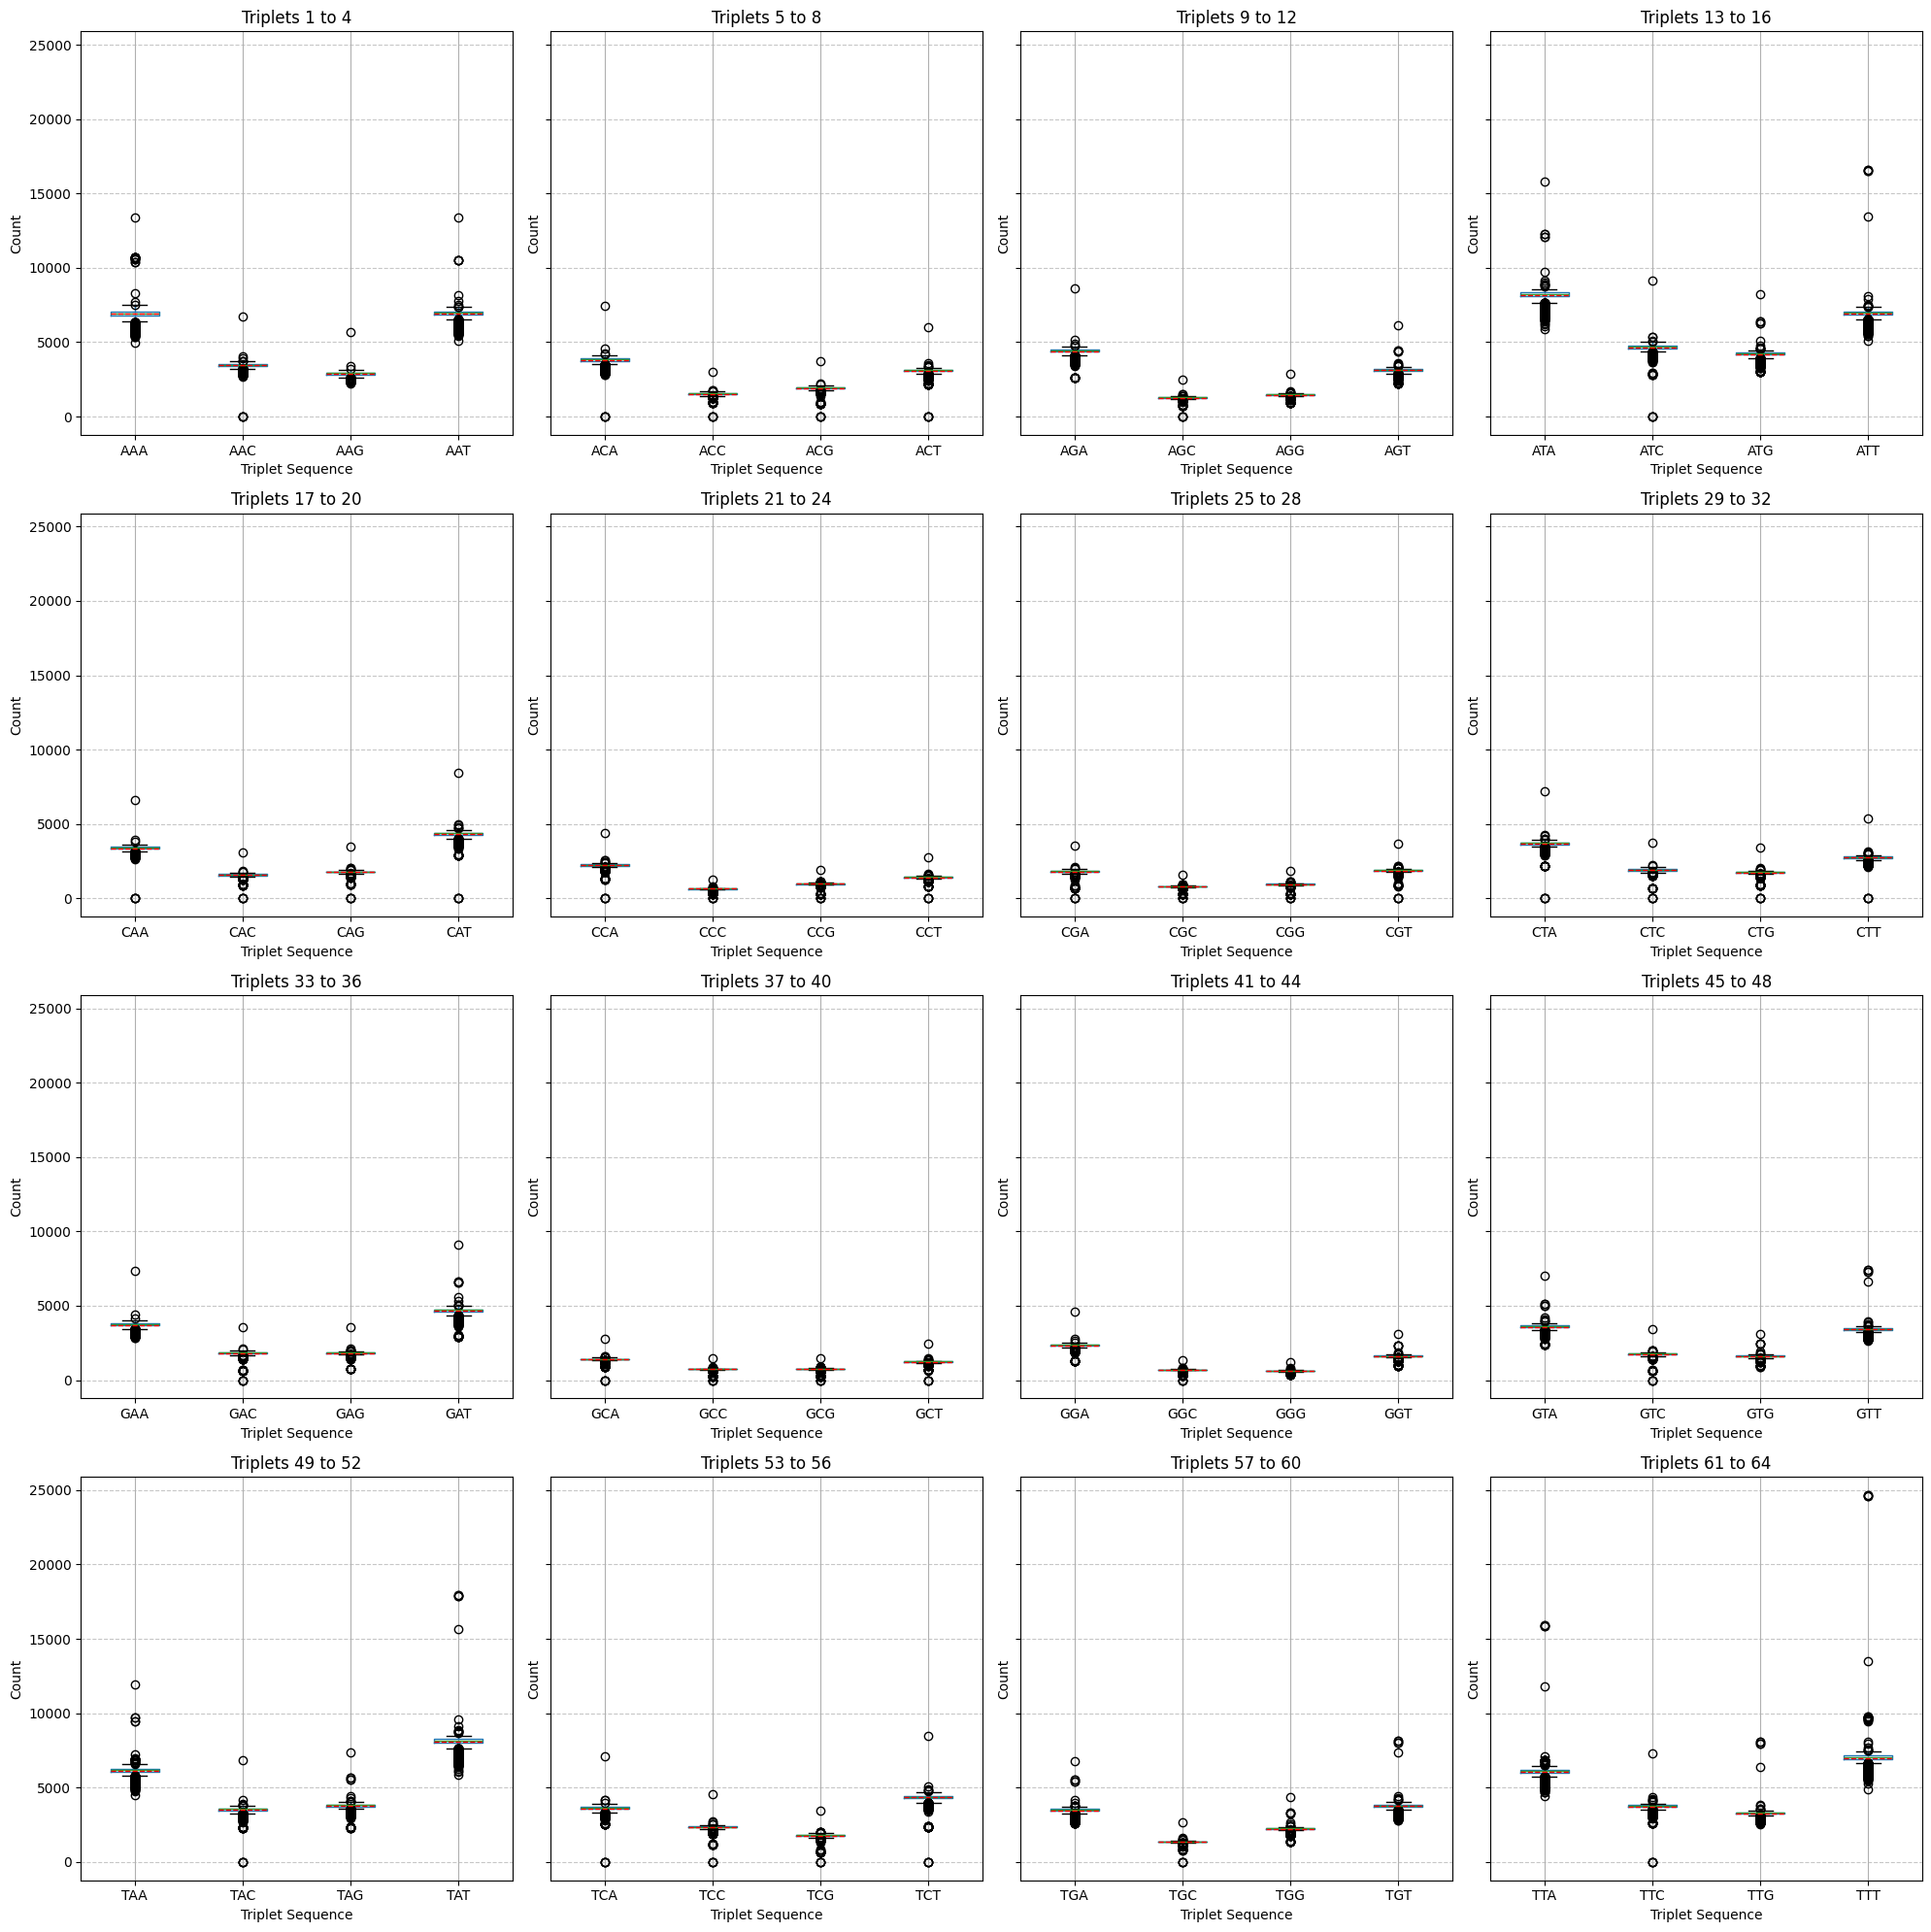


Files in /content: ['.config', 'n_count_updated.csv', 'complete_genomes_stats.csv', 'partial_genomes.csv', 'drive', 'complete_genomes.csv', 'sample_data']


In [10]:
import pandas as pd
import os
import matplotlib.pyplot as plt

def plot_triplet_boxplots(input_file):
    try:
        # Read the complete genomes CSV file
        df = pd.read_csv(input_file)

        # Check if DataFrame is empty
        if df.empty:
            print("Error: The input file is empty or contains no valid data.")
            return

        # Define triplet columns by filtering columns that are 3-character combinations of A, T, G, C
        valid_nucleotides = set('ATGC')
        triplet_cols = [col for col in df.columns if len(col) == 3 and set(col).issubset(valid_nucleotides)]
        triplet_cols = sorted(triplet_cols)  # Sort for consistent order

        # Verify that we have triplet columns
        if not triplet_cols:
            print("Error: No valid triplet columns (e.g., AAA, AAC, ...) found in the input file.")
            return
        if len(triplet_cols) != 64:
            print(f"Warning: Found {len(triplet_cols)} triplet columns instead of 64. Proceeding with available columns.")

        # Create a 4x4 grid of subplots
        fig, axes = plt.subplots(4, 4, figsize=(20, 20), sharey=True)
        axes = axes.flatten()  # Flatten to iterate easily

        # Create 16 plots, each with 4 box plots
        for i in range(16):
            # Select 4 triplet columns for the current plot
            start_idx = i * 4
            end_idx = min(start_idx + 4, len(triplet_cols))  # Ensure we don't exceed available columns
            current_cols = triplet_cols[start_idx:end_idx]

            if not current_cols:
                axes[i].set_visible(False)  # Hide empty subplot
                continue

            # Create box plot in the current subplot
            df[current_cols].boxplot(showmeans=True, meanline=True, meanprops={'linestyle': '--', 'color': 'red'}, ax=axes[i])
            axes[i].set_title(f'Triplets {start_idx+1} to {end_idx}')
            axes[i].set_xlabel('Triplet Sequence')
            axes[i].set_ylabel('Count')
            axes[i].grid(True, axis='y', linestyle='--', alpha=0.7)

        # Adjust layout to prevent overlap
        plt.tight_layout()
        plt.show()

        # Print files in /content to confirm no plots were saved
        print("\nFiles in /content:", os.listdir('/content'))

    except FileNotFoundError:
        print(f"Error: The file '{input_file}' was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: The file '{input_file}' is empty.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse '{input_file}'. Please check if it's a valid CSV file.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    print(f"Current working directory: {os.getcwd()}")
    input_csv = "complete_genomes.csv"  # Update path if needed, e.g., "/content/drive/MyDrive/complete_genomes.csv"
    plot_triplet_boxplots(input_csv)

# Removing Outliers and Again Visualize

In [11]:
import pandas as pd
import os
import plotly.graph_objects as go
from plotly.subplots import make_subplots

def remove_outliers_and_plot(input_genomes_file, input_stats_file, output_genomes_file):
    try:
        # Read the input files
        genomes_df = pd.read_csv(input_genomes_file)
        stats_df = pd.read_csv(input_stats_file)

        # Check if DataFrames are empty
        if genomes_df.empty:
            print("Error: The genomes file is empty or contains no valid data.")
            return
        if stats_df.empty:
            print("Error: The stats file is empty or contains no valid data.")
            return

        # Identify triplet columns (3-character combinations of A, T, G, C)
        valid_nucleotides = set('ATGC')
        triplet_cols = [col for col in genomes_df.columns if len(col) == 3 and set(col).issubset(valid_nucleotides)]
        triplet_cols = sorted(triplet_cols)

        # Verify triplet columns
        if not triplet_cols:
            print("Error: No valid triplet columns (e.g., AAA, AAC, ...) found in the genomes file.")
            return
        if len(triplet_cols) != 64:
            print(f"Warning: Found {len(triplet_cols)} triplet columns instead of 64. Proceeding with available columns.")

        # Ensure stats_df has the expected structure
        if not all(col in stats_df.columns for col in triplet_cols) or 'Statistic' not in stats_df.columns:
            print("Error: Stats file does not contain expected triplet columns or 'Statistic' column.")
            return

        # Create a copy of the genomes DataFrame
        cleaned_df = genomes_df.copy()

        # Remove outliers using Q1, Q3, and IQR from stats_df
        for col in triplet_cols:
            # Get Q1, Q3, and IQR from stats_df
            q1 = stats_df[stats_df['Statistic'] == 'Q1'][col].iloc[0]
            q3 = stats_df[stats_df['Statistic'] == 'Q3'][col].iloc[0]
            iqr = stats_df[stats_df['Statistic'] == 'IQR'][col].iloc[0]

            # Define outlier bounds
            lower_bound = q1 - 1.5 * iqr
            upper_bound = q3 + 1.5 * iqr

            # Filter rows where the column value is within bounds
            cleaned_df = cleaned_df[(cleaned_df[col] >= lower_bound) & (cleaned_df[col] <= upper_bound)]

        # Check if cleaned DataFrame is empty
        if cleaned_df.empty:
            print("Error: No data remains after removing outliers.")
            return

        # Save the cleaned DataFrame
        cleaned_df.to_csv(output_genomes_file, index=False)
        print(f"Cleaned genomes file '{output_genomes_file}' created successfully.")
        print(f"Shape: {cleaned_df.shape[0]} rows × {cleaned_df.shape[1]} columns")

        # Create a 4x4 grid of subplots
        fig = make_subplots(
            rows=4, cols=4,
            subplot_titles=[f'Triplets {(i*4)+1} to {min((i*4)+4, len(triplet_cols))}' for i in range(16)],
            shared_yaxes=True,
            vertical_spacing=0.1,
            horizontal_spacing=0.05
        )

        # Create box plots for each subplot
        for i in range(16):
            # Select 4 triplet columns for the current subplot
            start_idx = i * 4
            end_idx = min(start_idx + 4, len(triplet_cols))
            current_cols = triplet_cols[start_idx:end_idx]

            if not current_cols:
                continue  # Skip empty subplots

            # Add box plots to the subplot
            for j, col in enumerate(current_cols):
                fig.add_trace(
                    go.Box(
                        y=cleaned_df[col],
                        name=col,
                        showlegend=False,
                        boxmean=True,  # Show mean as a line
                        line=dict(color='blue'),
                        meanline=dict(visible=True, color='red', width=2)
                    ),
                    row=(i // 4) + 1,
                    col=(i % 4) + 1
                )

            # Update x-axis to show triplet names
            fig.update_xaxes(title_text='Triplet Sequence', tickvals=list(range(len(current_cols))), ticktext=current_cols, row=(i // 4) + 1, col=(i % 4) + 1)

        # Update y-axis for all subplots
        fig.update_yaxes(title_text='Count', showgrid=True, gridcolor='lightgray', zeroline=False)

        # Update layout for better appearance
        fig.update_layout(
            title_text='Box Plots for Triplet Sequences (No Outliers, Zoomable)',
            height=1200,
            width=1200,
            showlegend=False,
            margin=dict(t=100, b=50, l=50, r=50)
        )

        # Display the plot
        fig.show()

        # Print files in /content to confirm
        print("\nFiles in /content:", os.listdir('/content'))

    except FileNotFoundError:
        print(f"Error: One of the input files ('{input_genomes_file}' or '{input_stats_file}') was not found.")
    except pd.errors.EmptyDataError:
        print(f"Error: One of the input files is empty.")
    except pd.errors.ParserError:
        print(f"Error: Unable to parse one of the input files. Please check if they are valid CSV files.")
    except Exception as e:
        print(f"An unexpected error occurred: {str(e)}")

if __name__ == "__main__":
    print(f"Current working directory: {os.getcwd()}")
    input_genomes_csv = "complete_genomes.csv"  # Update path if needed
    input_stats_csv = "complete_genomes_stats.csv"  # Update path if needed
    output_genomes_csv = "complete_genomes_no_outliers.csv"
    remove_outliers_and_plot(input_genomes_csv, input_stats_csv, output_genomes_csv)

Current working directory: /content
Cleaned genomes file 'complete_genomes_no_outliers.csv' created successfully.
Shape: 5417 rows × 72 columns
An unexpected error occurred: Invalid property specified for object of type plotly.graph_objs.Box: 'meanline'

Did you mean "line"?

    Valid properties:
        alignmentgroup
            Set several traces linked to the same position axis or
            matching axes to the same alignmentgroup. This controls
            whether bars compute their positional range dependently
            or independently.
        boxmean
            If True, the mean of the box(es)' underlying
            distribution is drawn as a dashed line inside the
            box(es). If "sd" the standard deviation is also drawn.
            Defaults to True when `mean` is set. Defaults to "sd"
            when `sd` is set Otherwise defaults to False.
        boxpoints
            If "outliers", only the sample points lying outside the
            whiskers are shown If